In [7]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn, SKLearnModel
from sagemaker.serverless import ServerlessInferenceConfig
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
import uuid
    
from sklearn import ensemble as skens
from sklearn import metrics as skmet
from sklearn import model_selection as skmodsel
from sklearn import pipeline as skpln
from sklearn import compose as skcomp
from sklearn import impute as skimp
from sklearn import preprocessing as skpre

## Sagemaker Session

In [2]:
sagemaker_session = sagemaker.Session(default_bucket='sagemaker-sociedad-ec-estadistica')
region = sagemaker_session.boto_region_name
role = get_execution_role()

In [3]:
# Creación de la carpeta
os.makedirs("data", exist_ok=True)
os.makedirs("prepared", exist_ok=True)

## Data Load

In [4]:
# Descarga de datos
file_name = 'precio_casas.csv'
s3_client = boto3.client("s3")
s3_client.download_file("s3datossociedadecuatorianaestadistica", file_name, "./data/"+file_name)

In [8]:
# Lectura de datos
realstate_data = pd.read_csv("data/"+file_name)
realstate_data.head(1)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN


## EDA and Data Cleaning

In [9]:
realstate_data.head(10)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN
5,103378.0,for_sale,179000.0,4.0,3.0,0.46,1850806.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN
6,1205.0,for_sale,50000.0,3.0,1.0,0.20,1298094.0,Ciales,Puerto Rico,639.0,2040.0,NaN
7,50739.0,for_sale,71600.0,3.0,2.0,0.08,1048466.0,Ponce,Puerto Rico,731.0,1050.0,NaN
8,81909.0,for_sale,100000.0,2.0,1.0,0.09,734904.0,Ponce,Puerto Rico,730.0,1092.0,NaN
9,65672.0,for_sale,300000.0,5.0,3.0,7.46,1946226.0,Las Marias,Puerto Rico,670.0,5403.0,NaN


In [11]:
realstate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


In [12]:
realstate_data.status.value_counts()

status
for_sale          1389306
sold               812009
ready_to_build      25067
Name: count, dtype: int64

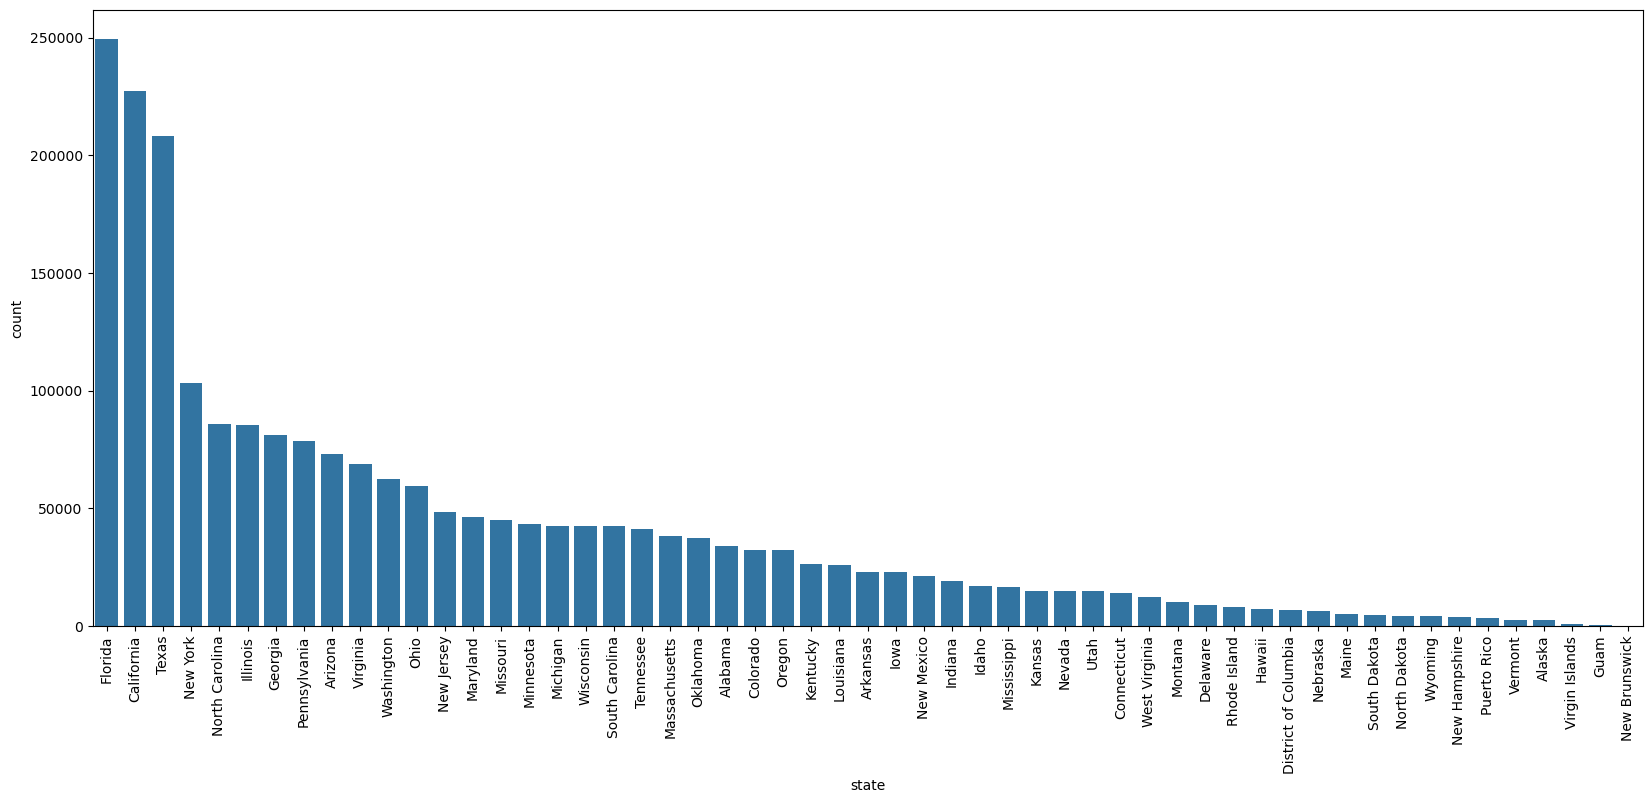

In [17]:
plt.figure(figsize = (20, 8))
sns.barplot(realstate_data.state.value_counts())
plt.xticks(rotation = 90)
plt.show()